## Classification with RF

In [1]:
from sklearn.datasets import load_iris
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn import ensemble, tree, metrics, clone
import numpy as np
from sklearn.model_selection import GridSearchCV

np.random.seed(10)  # set random seed

/Users/chench/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                    train_size=0.75, test_size=0.25)

rf_classifier = ensemble.RandomForestClassifier(n_estimators=10,  # number of trees
                       criterion='gini',  # or 'entropy' for information gain
                       max_depth=None,  # how deep tree nodes can go
                       min_samples_split=2,  # samples needed to split node
                       min_samples_leaf=1,  # samples needed for a leaf
                       min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                       max_features='auto',  # number of features for best split
                       max_leaf_nodes=None,  # max nodes
                       min_impurity_split=1e-07,  # early stopping
                       n_jobs=1,  # CPUs to use
                       random_state = 10,  # random seed
                       class_weight="balanced")  # adjusts weights inverse of freq, also "balanced_subsample" or None

model = rf_classifier.fit(X_train, y_train)

In [3]:
print("Score of model with test data defined above:")
print(model.score(X_test, y_test))
print()

predicted = model.predict(X_test)
print("Classification report:")
print(metrics.classification_report(y_test, predicted)) 
print()

scores = cross_val_score(model, iris.data, iris.target, cv=10)
print("10-fold cross-validation:")
print(scores)
print()

print("Average of 10-fold cross-validation:")
print(np.mean(scores))

Score of model with test data defined above:
0.947368421053

Classification report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        11
          1       0.93      0.93      0.93        15
          2       0.92      0.92      0.92        12

avg / total       0.95      0.95      0.95        38


10-fold cross-validation:
[ 1.          0.93333333  1.          0.93333333  0.93333333  0.86666667
  0.86666667  1.          1.          1.        ]

Average of 10-fold cross-validation:
0.953333333333


We can visualize and compare decision paths of decision trees and random forests:

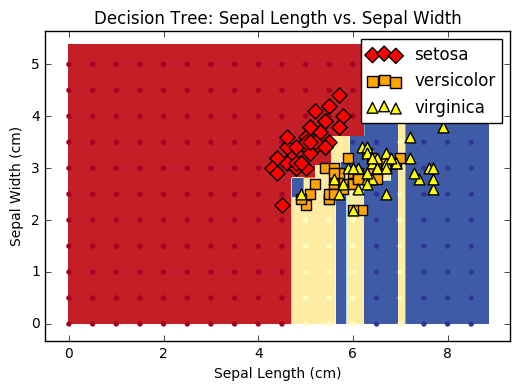

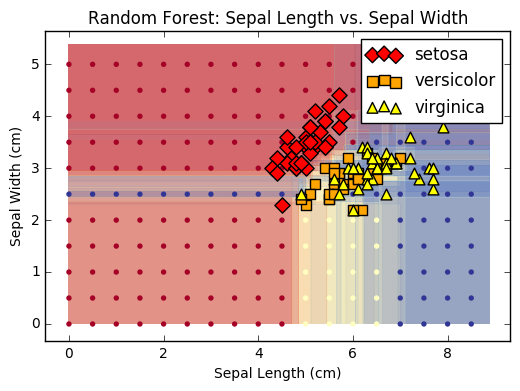

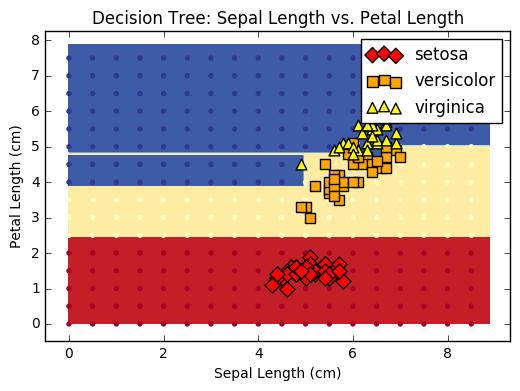

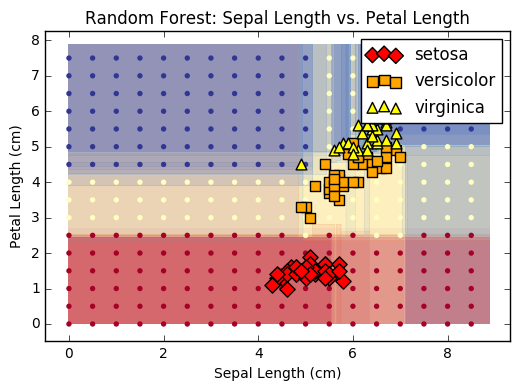

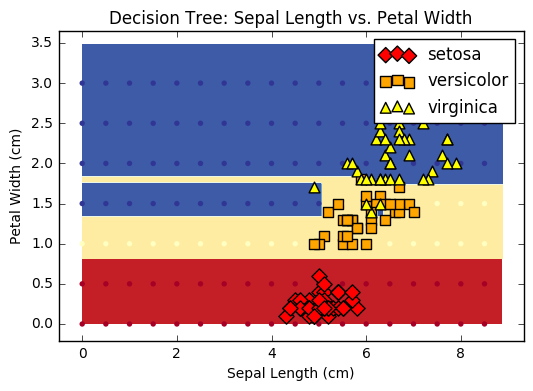

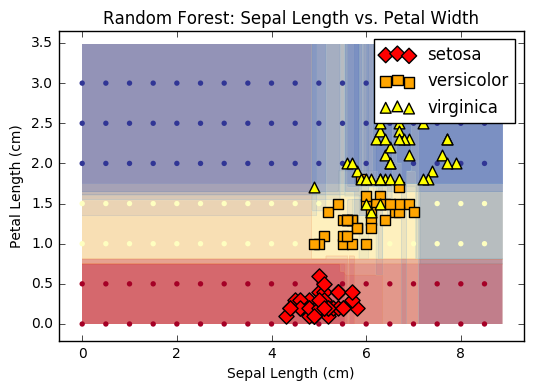

In [4]:
% matplotlib inline

# The visualization code below is adapted from:
# Copyright (c) 2016, Fairly Nerdy
# All rights reserved.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals.six.moves import xrange
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
plot_colors = ('r','orange','yellow','blue')
markers = ('D','s','^','o')

cmap = plt.cm.RdYlBu

plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses

models = [DecisionTreeClassifier(max_depth=None),
          ensemble.RandomForestClassifier(n_estimators=10)  ]
          
titles = ["Decision Tree: Sepal Length vs. Sepal Width",
          "Random Forest: Sepal Length vs. Sepal Width",
          "Decision Tree: Sepal Length vs. Petal Length",
          "Random Forest: Sepal Length vs. Petal Length",
          "Decision Tree: Sepal Length vs. Petal Width",
          "Random Forest: Sepal Length vs. Petal Width"]
cnt1 = 0
y_labels = ['Sepal Width (cm)','Sepal Width (cm)',
            'Petal Length (cm)','Petal Length (cm)',
            'Petal Width (cm)', 'Petal Length (cm)']

labels = iris.target_names

for pair in ([0,1], [0,2], [0,3]):
    for model in models:
        # We only take the two corresponding features
        X = np.asarray([[x[pair[0]], x[pair[1]]] for x in X_train])
        y = y_train.astype(np.float)
        
        np.random.seed(10)

        # Train
        clf = clone(model)
        clf = model.fit(X, y)

        scores = clf.score(X, y)
        
        model_title = titles[cnt1]
        plt.title(model_title)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = 0, X[:, 0].max() + 1
        y_min, y_max = 0, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number of estimators
            # that are in use 
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a black outline
        xx_coarser, yy_coarser = np.meshgrid(np.arange(x_min, x_max, plot_step_coarser),
                                             np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(), yy_coarser.ravel()]).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15, c=Z_points_coarser, cmap=cmap, edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        for i, c in zip(xrange(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=c, cmap=cmap,s=60,marker=markers[i],
                        label=labels[i])
            plt.legend(loc=1)
            plt.xlabel('Sepal Length (cm)')
            plt.ylabel(y_labels[cnt1])


        plt.show()
        cnt1+=1

## Regression with RFs

In [5]:
from sklearn.cross_validation import train_test_split
from sklearn.datasets import load_boston
from sklearn import ensemble

np.random.seed(10)  # set random seed

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    train_size=0.75, test_size=0.25)

rf_reg = ensemble.RandomForestRegressor(n_estimators=10,  # number of trees
                                        criterion='mse',  # how to measure fit
                                        max_depth=None,  # how deep tree nodes can go
                                        min_samples_split=2,  # samples needed to split node
                                        min_samples_leaf=1,  # samples needed for a leaf
                                        min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                                        max_features='auto',  # max feats
                                        max_leaf_nodes=None,  # max nodes
                                        random_state = 10,  # random seed
                                        n_jobs=1)  # how many to run parallel

model = rf_reg.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.849199501843


In [6]:
print("Score of model with test data defined above:")
print(model.score(X_test, y_test))
print()

scores = cross_val_score(model, boston.data, boston.target, cv=10)
print("10-fold cross-validation:")
print(scores)
print()

print("Average of 10-fold cross-validation:")
print(np.mean(scores))

Score of model with test data defined above:
0.849199501843

10-fold cross-validation:
[ 0.58439266  0.75659953  0.44603435  0.81334244  0.82220169  0.51881378
  0.50401845  0.30554186 -0.81060968  0.17923045]

Average of 10-fold cross-validation:
0.41195655359


### Grid Search

In [7]:
param_grid = {'min_samples_split': range(2,10),
              'min_samples_leaf': range(1,10)}

model_r = GridSearchCV(ensemble.RandomForestRegressor(), param_grid)
model_r.fit(X_train, y_train)

best_index = np.argmax(model_r.cv_results_["mean_test_score"])

print(model_r.cv_results_["params"][best_index])
print(max(model_r.cv_results_["mean_test_score"]))
print(model_r.score(X_test, y_test))

{'min_samples_leaf': 1, 'min_samples_split': 4}
0.815716366844
0.829178540614
